# Curitiba - Base do 156

Este é um projeto de análise dos dados da base do 156. Consiste em um importador dos dados, um processador, visualizador e, por último exportando os dados em formato Feather.

In [3]:
import qgrid
import matplotlib.pyplot as plt

from curitiba_dados_abertos.datasources import DS156

# Leitura dos dados
Nesse momento os dados são importados por meio da função get_downloaded_base156. Basicamente ele consulta o site do 156, pega o último arquivo CSV e o salva no arquivo `source_data/base_156.csv`. A saída desse comando já entra dentro do pandas por meio do `csv_file` e `encoding`.

In [4]:
ds156 = DS156()

In [5]:
data = ds156.get_pandas_dataframe(date_prefix='2016-09-01')

In [6]:
ds156.list_available_items()

['2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-04-26',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01',
 '2020-01-01',
 '2020-02-01']

# Apresentação dos dados
## Dado separado por assunto

In [10]:
data_assunto = data[['ASSUNTO']].groupby(['ASSUNTO']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)
qgrid.show_grid(data_assunto)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Organização por tipo de órgão


In [13]:
data_orgaos = data[['ORGAO']].groupby(['ORGAO']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)
qgrid.show_grid(data_orgaos)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Visualização do Grid inteiro

In [11]:
qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Gráfico de solicitação por Bairro

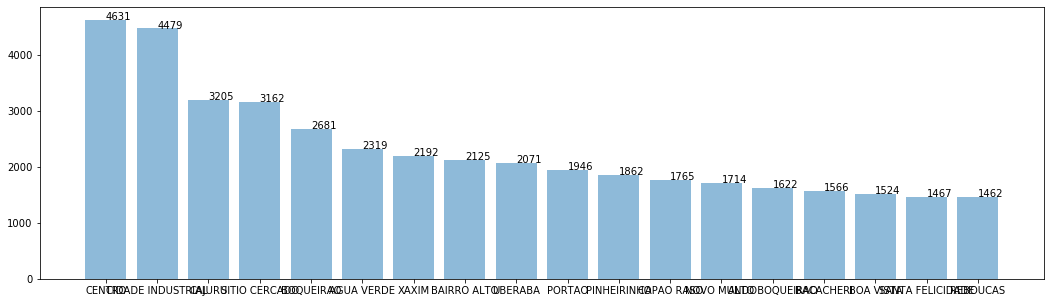

In [7]:
data_top_bairros = data.groupby('BAIRRO_ASS')['BAIRRO_ASS'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(18)

plt.figure(figsize=(18,5))
plt.bar(data_top_bairros['BAIRRO_ASS'], data_top_bairros['count'], align='center', alpha=0.5)

for a,b in zip(data_top_bairros['BAIRRO_ASS'], data_top_bairros['count']):
    plt.text(a, b, str(b))

plt.show()